In [1]:
import math
import torch
import gpytorch
from gpytorch.kernels import RBFKernel
from matplotlib import pyplot as plt
import numpy as np
import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [136]:
data = np.genfromtxt("../../heron/models/data/gt-all-apr2020.dat")[:5000]

In [137]:
data[:,:8] = data[:,:8] + 1e-6*np.random.randn(*data[:,:8].shape)

In [138]:
data[:,0] = (data[:,0] + 300) / 400.

In [139]:
training_x = torch.tensor(data[:,:8]).float().cuda()
training_y = torch.tensor(data[:,[-2, -1]]).float().cuda()

In [140]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(training_x, training_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [141]:
from functools import reduce
import operator
def prod(iterable):
    return reduce(operator.mul, iterable)

In [142]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

In [159]:
class TorchBigHeron(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        
        
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(-2), 
            batch_shape=torch.Size([2]))
        
        variational_strategy = gpytorch.variational.MultitaskVariationalStrategy(
            VariationalStrategy(self, inducing_points, 
                                variational_distribution, 
                                learn_inducing_locations=True),
            num_tasks=2)
        
        super(TorchBigHeron, self).__init__(variational_strategy)
        
        self.mean_module =  gpytorch.means.ConstantMean(batch_shape=torch.Size([2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            RBFKernel(ard_num_dims=8, 
                      batch_shape=torch.Size([2]), 
                      #lengthscale_prior = gpytorch.priors.GammaPrior(0.3, 0.3),
                      lengthscale_constraint=gpytorch.constraints.LessThan(1e-2)
                     ))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [160]:
inducing_points = torch.tensor(np.dstack([training_x.cpu()[np.random.choice(np.arange(len(training_x.cpu())), 500),:].T, training_x.cpu()[np.random.choice(np.arange(len(training_x.cpu())), 500),:].T]).T).cuda()

In [161]:
# torch.tensor(np.dstack([training_x[:500,:].T, training_x[:500,:].T]))
#inducing_points[:,:,0]*=100
model = TorchBigHeron(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)

In [162]:
model = model.cuda()
likelihood = likelihood.cuda()

In [169]:
num_epochs = 1000

model.train()
likelihood.train()

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.05)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=training_y.size(0))


epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.tqdm_notebook(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
torch.save(model.state_dict(), 'model_state.pth')

/home/daniel/.virtualenvs/gaston/sandbox/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/home/daniel/.virtualenvs/gaston/sandbox/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [164]:
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (noise_covar): MultitaskHomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [165]:
test_x = torch.tensor(data[0:50, :8]).float().cuda()
test_y = torch.tensor(data[0:50, -2]).float().cuda()


In [166]:
test_x = np.ones([1000, 8]) 
test_x = test_x * data[0, :8]
test_x[:,0] = np.linspace(0, 1.0, 1000)
test_x[:,1] = np.ones(1000) * 1.0
test_x[:,2:] = np.ones((1000,6)) * [0.,0,-0,0,0,0.0]
test_x = torch.tensor(test_x).float().cuda()

In [167]:
#%%timeit
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f_preds = model(test_x)
    y_preds = likelihood(f_preds)

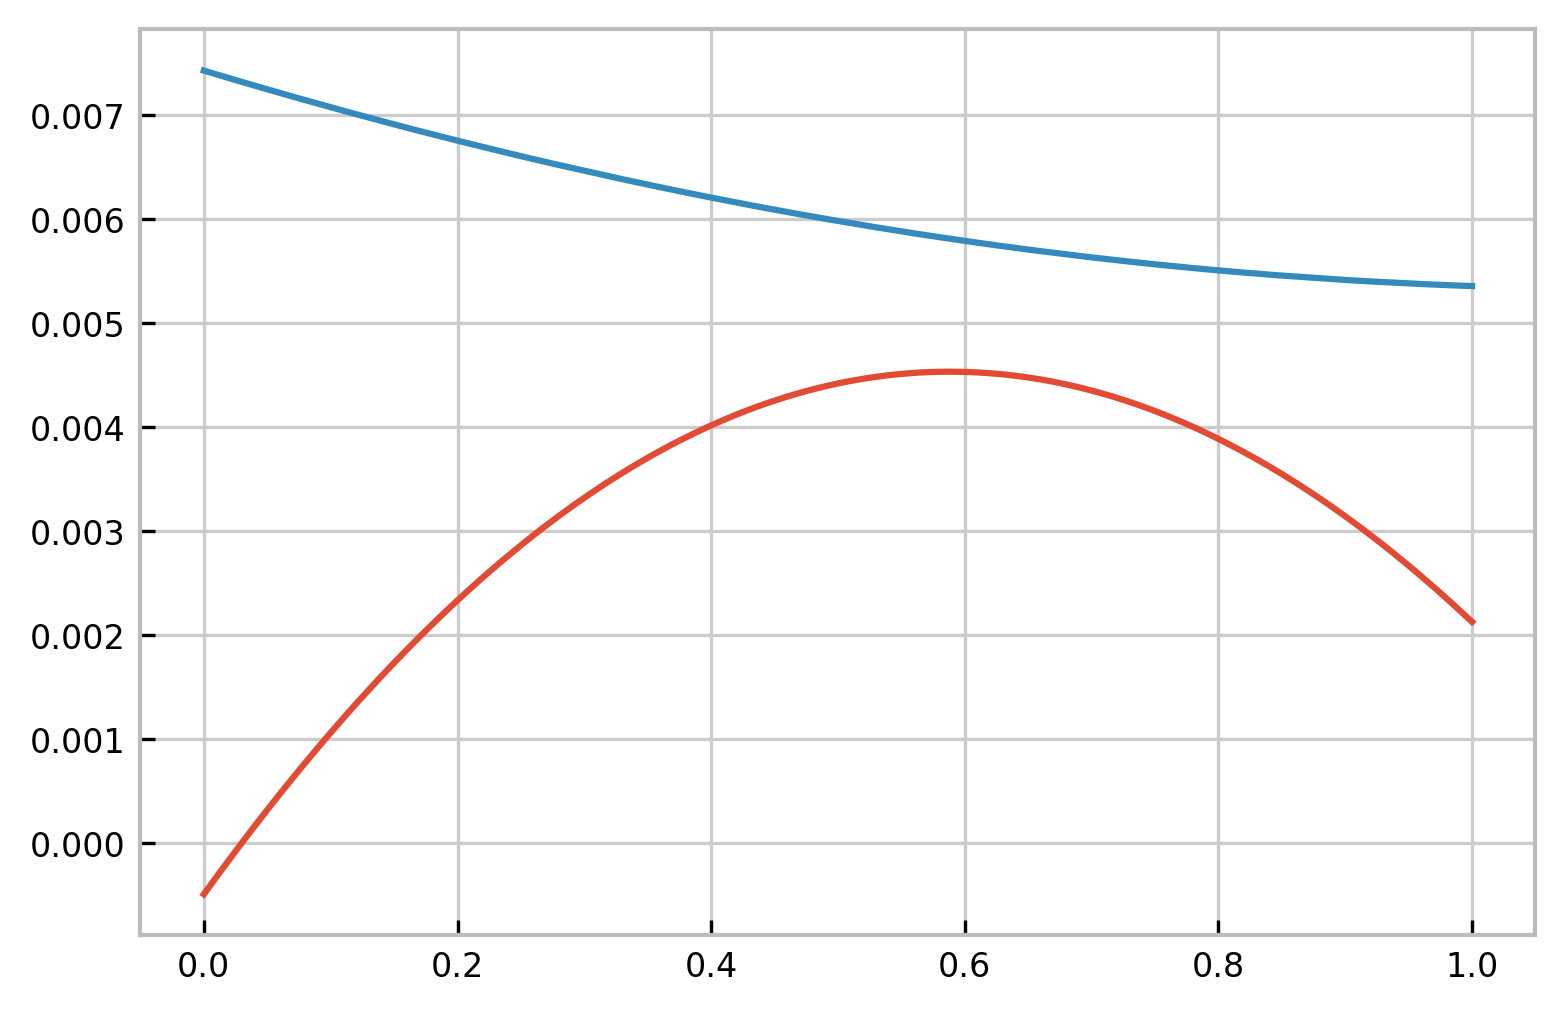

In [168]:
with torch.no_grad():
    lower, upper = y_preds.confidence_region()
    f, ax = plt.subplots(1,1, dpi=300)
    ax.plot(test_x[:,0].cpu().numpy(), f_preds.mean.cpu().numpy()[:,0])
    ax.plot(test_x[:,0].cpu().numpy(), f_preds.mean.cpu().numpy()[:,1])
    
    #samples = y_preds.sample_n(100)
    #for sample in samples:
    #    ax.plot(test_x[:,0].numpy(), sample.numpy()[:,0], alpha=0.01, color='r')
    #    ax.plot(test_x[:,0].numpy(), sample.numpy()[:,1], alpha=0.01, color='b')
    
    #ax.fill_between(test_x[:,0].cpu().numpy(), lower[:,0].cpu().numpy()**2, upper[:,0].cpu().numpy()**2, alpha=0.5)

In [154]:
test_x = np.ones([1000, 8]) 
test_x = test_x * data[0, :8]
test_x[:,0] = np.linspace(-300, 100, 1000)
test_x[:,1] = np.ones(1000) * 0.01
test_x[:,2:] = np.ones((1000,6)) * [0.1,0,-0,0,0,0.0]
test_x = torch.tensor(test_x).float().cuda()

In [ ]:
#%%timeit
with torch.no_grad(): #, gpytorch.settings.fast_pred_var():
    f_preds = model(test_x)
    y_preds = likelihood(f_preds)

In [ ]:
with torch.no_grad():
    lower, upper = y_preds.confidence_region()
    f, ax = plt.subplots(1,1, dpi=300)
    ax.plot(test_x[:,0].cpu().numpy(), f_preds.mean.cpu().numpy()[:,0])
    #ax.plot(test_x[:,0].cpu().numpy(), f_preds.mean.cpu().numpy()[:,1])
    
    #samples = y_preds.sample_n(100)
    #for sample in samples:
    #    ax.plot(test_x[:,0].numpy(), sample.numpy()[:,0], alpha=0.01, color='r')
    #    ax.plot(test_x[:,0].numpy(), sample.numpy()[:,1], alpha=0.01, color='b')
    
    #ax.fill_between(test_x[:,0].numpy(), lower[0].numpy(), upper.numpy(), alpha=0.5)